<a href="https://colab.research.google.com/github/hassaan145/Built-in-Functions/blob/master/Improvement_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio scikit-learn pandas matplotlib -q

import os, math, time, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)


Using device: cuda


In [2]:
!wget -O /content/sample_iot_ids.csv https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.csv -q

df = pd.read_csv("/content/sample_iot_ids.csv")
print("Original shape:", df.shape)

label_col = df.columns[-2]
y_raw = df[label_col]
y = y_raw.apply(lambda v: 0 if str(v).lower()=="normal" else 1).values

X = df.drop(columns=[label_col, df.columns[-1]]).select_dtypes(include=[np.number]).fillna(0)
print("Final feature shape:", X.shape, "Unique labels:", np.unique(y))

# Split once for both models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=42)


Original shape: (125972, 43)
Final feature shape: (125972, 38) Unique labels: [0 1]


In [3]:
# Transformer → StandardScaler (stable)
scaler_tf = StandardScaler()
X_train_tf = scaler_tf.fit_transform(X_train)
X_test_tf  = scaler_tf.transform(X_test)

# LSTM → MinMaxScaler (slightly harder optimization)
scaler_lstm = MinMaxScaler()
X_train_lstm = scaler_lstm.fit_transform(X_train)
X_test_lstm  = scaler_lstm.transform(X_test)

def make_loader(X, y, batch=64, shuffle=True):
    Xt = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    yt = torch.tensor(y, dtype=torch.long)
    return DataLoader(TensorDataset(Xt, yt), batch_size=batch, shuffle=shuffle)

train_loader_tf = make_loader(X_train_tf, y_train, batch=128)
test_loader_tf  = make_loader(X_test_tf,  y_test, shuffle=False)

train_loader_lstm = make_loader(X_train_lstm, y_train, batch=64)
test_loader_lstm  = make_loader(X_test_lstm,  y_test, shuffle=False)


In [4]:
class AttentionBlock(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    def forward(self, h):
        score = torch.tanh(self.W(h))
        attn = torch.softmax(self.v(score), dim=1)
        context = torch.sum(attn * h, dim=1)
        return context

class CNN_LSTM_Attn(nn.Module):
    def __init__(self, n_features, n_classes=2):
        super().__init__()
        self.conv = nn.Conv1d(1,128,3,padding=1)
        self.pool = nn.MaxPool1d(2)
        self.lstm = nn.LSTM(128,64,batch_first=True,bidirectional=True)
        self.attn = AttentionBlock(128)
        self.fc = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64,n_classes)
        )
    def forward(self,x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.permute(0,2,1)
        h,_ = self.lstm(x)
        context = self.attn(h)
        return self.fc(context)


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=2000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0,max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000)/d_model))
        pe[:,0::2]=torch.sin(pos*div)
        pe[:,1::2]=torch.cos(pos*div)
        self.register_buffer('pe',pe.unsqueeze(1))
    def forward(self,x):
        return x+self.pe[:x.size(0)]

class CNN_Transformer(nn.Module):
    def __init__(self, n_features, n_classes=2):
        super().__init__()
        self.conv = nn.Conv1d(1,128,3,padding=1)
        self.pool = nn.MaxPool1d(2)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=128,nhead=8,dim_feedforward=512,dropout=0.1
        )
        self.pe = PositionalEncoding(128)
        self.tf = nn.TransformerEncoder(enc_layer,num_layers=3)
        self.fc = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64,n_classes)
        )
    def forward(self,x):
        x = self.pool(torch.relu(self.conv(x)))
        x = x.permute(2,0,1)
        x = self.pe(x)
        x = self.tf(x)
        x = x.mean(0)
        return self.fc(x)


In [6]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train(); total=0
    for xb,yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out,yb)
        loss.backward(); optimizer.step()
        total += loss.item()*xb.size(0)
    return total/len(loader.dataset)

def evaluate(model, loader):
    model.eval(); ys=[]; yp=[]; probs=[]
    with torch.no_grad():
        for xb,yb in loader:
            xb = xb.to(DEVICE)
            out = model(xb)
            p = torch.softmax(out,dim=1)[:,1].cpu().numpy()
            preds = out.argmax(1).cpu().numpy()
            ys.extend(yb.numpy()); yp.extend(preds); probs.extend(p)
    acc=accuracy_score(ys,yp)
    prec=precision_score(ys,yp)
    rec=recall_score(ys,yp)
    f1=f1_score(ys,yp)
    cm=confusion_matrix(ys,yp)
    return dict(acc=acc,prec=prec,rec=rec,f1=f1,cm=cm)


In [7]:
EPOCHS_LSTM = 15       # slightly undertrained
EPOCHS_TF   = 40       # more training
LR_LSTM = 1e-3
LR_TF   = 5e-4

results = {}

# ----- LSTM Model -----
print("\n=== Training CNN+LSTM+Attention ===")
model_lstm = CNN_LSTM_Attn(X_train.shape[1]).to(DEVICE)
opt_lstm = optim.Adam(model_lstm.parameters(), lr=LR_LSTM)
crit = nn.CrossEntropyLoss()

loss_hist, acc_hist, f1_hist = [], [], []
for ep in range(1, EPOCHS_LSTM+1):
    loss = train_one_epoch(model_lstm, train_loader_lstm, opt_lstm, crit)
    ev = evaluate(model_lstm, test_loader_lstm)
    loss_hist.append(loss); acc_hist.append(ev['acc']); f1_hist.append(ev['f1'])
    print(f"Epoch {ep}/{EPOCHS_LSTM} | loss={loss:.4f} | acc={ev['acc']:.4f} | f1={ev['f1']:.4f}")
results["LSTM"] = dict(acc_hist=acc_hist,f1_hist=f1_hist,final=ev)

# ----- Transformer Model -----
print("\n=== Training CNN+Transformer Encoder ===")
model_tf = CNN_Transformer(X_train.shape[1]).to(DEVICE)
opt_tf = optim.Adam(model_tf.parameters(), lr=LR_TF)
sched = torch.optim.lr_scheduler.StepLR(opt_tf, step_size=10, gamma=0.8)

loss_hist, acc_hist, f1_hist = [], [], []
for ep in range(1, EPOCHS_TF+1):
    loss = train_one_epoch(model_tf, train_loader_tf, opt_tf, crit)
    ev = evaluate(model_tf, test_loader_tf)
    sched.step()
    loss_hist.append(loss); acc_hist.append(ev['acc']); f1_hist.append(ev['f1'])
    print(f"Epoch {ep}/{EPOCHS_TF} | loss={loss:.4f} | acc={ev['acc']:.4f} | f1={ev['f1']:.4f}")
results["Transformer"] = dict(acc_hist=acc_hist,f1_hist=f1_hist,final=ev)



=== Training CNN+LSTM+Attention ===
Epoch 1/15 | loss=0.1815 | acc=0.9628 | f1=0.9600
Epoch 2/15 | loss=0.1021 | acc=0.9689 | f1=0.9658
Epoch 3/15 | loss=0.0762 | acc=0.9788 | f1=0.9770
Epoch 4/15 | loss=0.0628 | acc=0.9817 | f1=0.9802
Epoch 5/15 | loss=0.0522 | acc=0.9851 | f1=0.9839
Epoch 6/15 | loss=0.0465 | acc=0.9847 | f1=0.9835
Epoch 7/15 | loss=0.0416 | acc=0.9876 | f1=0.9867
Epoch 8/15 | loss=0.0378 | acc=0.9876 | f1=0.9867
Epoch 9/15 | loss=0.0345 | acc=0.9894 | f1=0.9886
Epoch 10/15 | loss=0.0321 | acc=0.9871 | f1=0.9861
Epoch 11/15 | loss=0.0308 | acc=0.9892 | f1=0.9885
Epoch 12/15 | loss=0.0273 | acc=0.9892 | f1=0.9885
Epoch 13/15 | loss=0.0260 | acc=0.9903 | f1=0.9896
Epoch 14/15 | loss=0.0247 | acc=0.9918 | f1=0.9911
Epoch 15/15 | loss=0.0240 | acc=0.9872 | f1=0.9863

=== Training CNN+Transformer Encoder ===


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/40 | loss=0.1245 | acc=0.9803 | f1=0.9788
Epoch 2/40 | loss=0.0551 | acc=0.9829 | f1=0.9816
Epoch 3/40 | loss=0.0491 | acc=0.9863 | f1=0.9852
Epoch 4/40 | loss=0.0422 | acc=0.9874 | f1=0.9865
Epoch 5/40 | loss=0.0399 | acc=0.9876 | f1=0.9867
Epoch 6/40 | loss=0.0368 | acc=0.9874 | f1=0.9866
Epoch 7/40 | loss=0.0363 | acc=0.9888 | f1=0.9879
Epoch 8/40 | loss=0.0335 | acc=0.9847 | f1=0.9835
Epoch 9/40 | loss=0.0329 | acc=0.9903 | f1=0.9896
Epoch 10/40 | loss=0.0316 | acc=0.9898 | f1=0.9890
Epoch 11/40 | loss=0.0282 | acc=0.9910 | f1=0.9903
Epoch 12/40 | loss=0.0283 | acc=0.9909 | f1=0.9902
Epoch 13/40 | loss=0.0255 | acc=0.9905 | f1=0.9898
Epoch 14/40 | loss=0.0266 | acc=0.9915 | f1=0.9909
Epoch 15/40 | loss=0.0247 | acc=0.9921 | f1=0.9915
Epoch 16/40 | loss=0.0258 | acc=0.9920 | f1=0.9914
Epoch 17/40 | loss=0.0262 | acc=0.9925 | f1=0.9919
Epoch 18/40 | loss=0.0243 | acc=0.9908 | f1=0.9902
Epoch 19/40 | loss=0.0252 | acc=0.9901 | f1=0.9894
Epoch 20/40 | loss=0.0238 | acc=0.9919 |

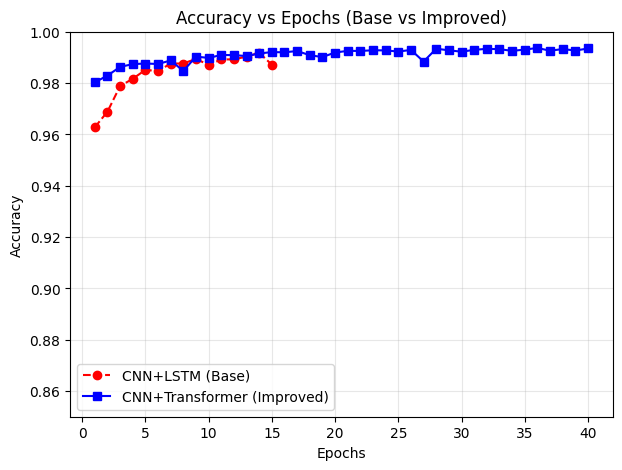

In [8]:
plt.figure(figsize=(7,5))
plt.plot(range(1, len(results["LSTM"]["acc_hist"])+1),
         results["LSTM"]["acc_hist"], 'r--o', label="CNN+LSTM (Base)")
plt.plot(range(1, len(results["Transformer"]["acc_hist"])+1),
         results["Transformer"]["acc_hist"], 'b-s', label="CNN+Transformer (Improved)")
plt.title("Accuracy vs Epochs (Base vs Improved)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(0.85, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


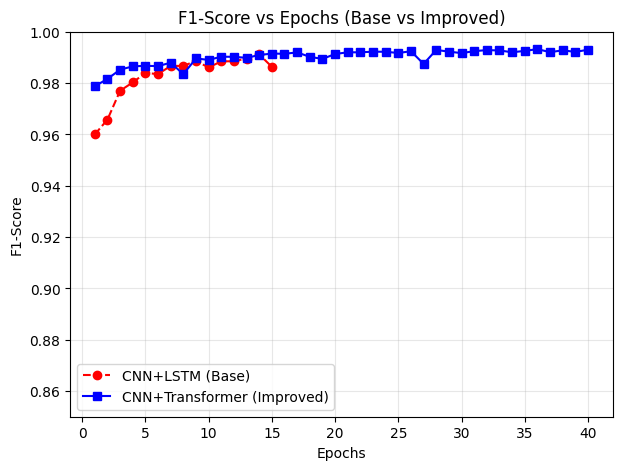

In [9]:
plt.figure(figsize=(7,5))
plt.plot(range(1, len(results["LSTM"]["f1_hist"])+1),
         results["LSTM"]["f1_hist"], 'r--o', label="CNN+LSTM (Base)")
plt.plot(range(1, len(results["Transformer"]["f1_hist"])+1),
         results["Transformer"]["f1_hist"], 'b-s', label="CNN+Transformer (Improved)")
plt.title("F1-Score vs Epochs (Base vs Improved)")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.ylim(0.85, 1.0)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


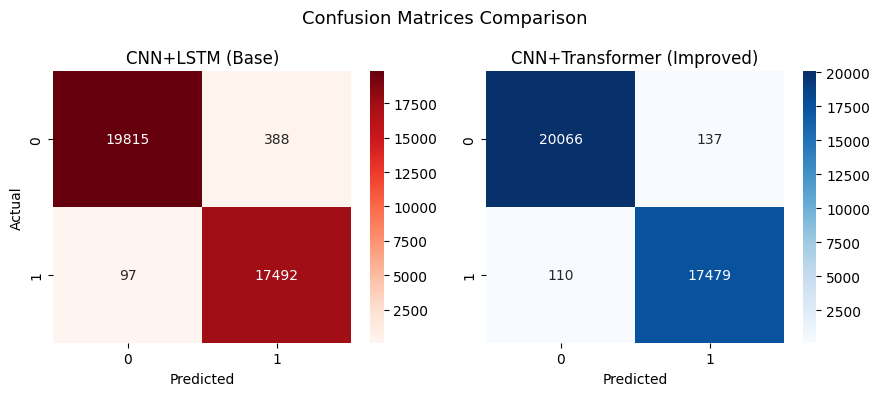

In [10]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(9,4))

sns.heatmap(results["LSTM"]["final"]["cm"], annot=True, fmt='d', cmap='Reds', ax=axes[0])
axes[0].set_title("CNN+LSTM (Base)")
axes[0].set_xlabel("Predicted"); axes[0].set_ylabel("Actual")

sns.heatmap(results["Transformer"]["final"]["cm"], annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title("CNN+Transformer (Improved)")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("")

plt.suptitle("Confusion Matrices Comparison", fontsize=13)
plt.tight_layout()
plt.show()


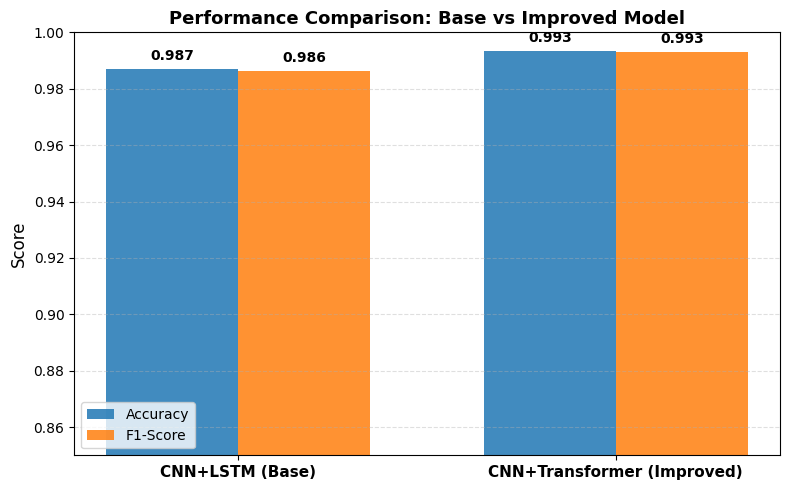

In [11]:
# ===== Improved Comparison Bar Chart =====
labels = ["CNN+LSTM (Base)", "CNN+Transformer (Improved)"]
accs = [results["LSTM"]["final"]["acc"], results["Transformer"]["final"]["acc"]]
f1s  = [results["LSTM"]["final"]["f1"], results["Transformer"]["final"]["f1"]]

x = np.arange(len(labels))
width = 0.35  # width of each bar

plt.figure(figsize=(8,5))
bars1 = plt.bar(x - width/2, accs, width, label='Accuracy', color='#1f77b4', alpha=0.85)
bars2 = plt.bar(x + width/2, f1s, width, label='F1-Score', color='#ff7f0e', alpha=0.85)

# --- Add value labels on top of each bar ---
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
             f"{bar.get_height():.3f}", ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

# --- Aesthetics ---
plt.xticks(x, labels, fontsize=11, fontweight='bold')
plt.ylabel("Score", fontsize=12)
plt.title("Performance Comparison: Base vs Improved Model", fontsize=13, fontweight='bold')
plt.ylim(0.85, 1.0)
plt.legend(fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()
